In [1]:
import pandas as pd
from tqdm import tqdm
from mltb2.transformers import TransformersTokenCounter
from mltb2.somajo_transformers import TextSplitter
from mltb2.somajo import SoMaJoSentenceSplitter
import numpy as np

tqdm.pandas()  # activate tqdm pandas progress bar support

In [2]:
MAX_TOKEN_COUNT = 270

In [3]:
df = pd.read_pickle("./data/wikipedia-22-12-de-no-emb-clean-selected.pkl.gz")
df

,id,title,text,wiki_id,paragraph_id
6983787,6983787,Friedrich Stromeyer,Er heiratete Luise Ludewig (* 29. September 17...,784611,5
13332431,13332431,Siddiqiy Ajziy,"Saidahmad Siddiqiy (auch ""Saidahmadxoʻja""; kyr...",5871091,0
3440127,3440127,"7,5-cm-Leichtgeschütz 40","Das 7,5-cm-Leichtgeschütz 40 (kurz ""LG 40"") wa...",5365282,0
13755596,13755596,Tiberius Claudius Claudianus,<onlyinclude>* Tiberius Claudius Claudianus (S...,12114918,0
8987544,8987544,Gmina Stargard,Weitere Ortschaften in der Gemeinde sind Bębni...,7596131,2
...,...,...,...,...,...
7250546,7250546,Rigomagus,Nach dem Bataveraufstand und den Wirren des Vi...,5517172,8
2057137,2057137,Paul Ryan (Politiker),"In seinem ersten Versuch, in den Vereinigten S...",5589493,11
1280074,1280074,Hacker (Computersicherheit),1988 schreibt Robert Tappan Morris aus Neugier...,1661063,18
14410373,14410373,Anna Margarethe van Delden,Anna Margarete van Delden wurde am 10. Dezembe...,11669155,1


In [4]:
token_counter = TransformersTokenCounter("deepset/gbert-base")
somajo_sentence_splitter = SoMaJoSentenceSplitter(language="de_CMC")


In [5]:
wiki_ids = df["wiki_id"].unique()

# FIXME: remove this - it is just for testing
# wiki_ids = wiki_ids[:1_000]

_selected_chunks = []
_titles = []
_wiki_ids = []

for wiki_id in tqdm(wiki_ids):
    df_wiki_id = df[df["wiki_id"] == wiki_id].copy().sort_values("paragraph_id")

    assert len(df_wiki_id["title"].unique()) == 1
    assert len(df_wiki_id["wiki_id"].unique()) == 1
    title = df_wiki_id.iloc[0]["title"]
    wiki_id = df_wiki_id.iloc[0]["wiki_id"]

    # random integer number between 80 and 252
    max_token = np.random.randint(120, 400)
    if max_token > MAX_TOKEN_COUNT:
        max_token = MAX_TOKEN_COUNT

    text_splitter = TextSplitter(
        max_token=max_token,
        somajo_sentence_splitter=somajo_sentence_splitter,
        transformers_token_counter=token_counter,
        ignore_overly_long_sentences=True,
    )

    texts = df_wiki_id["text"].tolist()
    text = " ".join(texts)
    text_chunks = text_splitter(text)
    if len(text_chunks) > 0:
        selected_chunk = text_chunks[0]
        assert isinstance(selected_chunk, str)
        assert len(selected_chunk) > 0

        _selected_chunks.append(selected_chunk)
        _titles.append(title)
        _wiki_ids.append(wiki_id)

100%|██████████| 136720/136720 [51:32<00:00, 44.21it/s] 


In [6]:
train_df = pd.DataFrame(
    {"wiki_id": _wiki_ids, "title": _titles, "text": _selected_chunks}
)
train_df

,wiki_id,title,text
0,784611,Friedrich Stromeyer,Friedrich Stromeyer (* 2. August 1776 in Götti...
1,5871091,Siddiqiy Ajziy,"Saidahmad Siddiqiy (auch ""Saidahmadxoʻja""; kyr..."
2,5365282,"7,5-cm-Leichtgeschütz 40","Das 7,5-cm-Leichtgeschütz 40 (kurz ""LG 40"") wa..."
3,12114918,Tiberius Claudius Claudianus,<onlyinclude>* Tiberius Claudius Claudianus (S...
4,7596131,Gmina Stargard,"Die Gmina Stargard (von 1950 bis 2015 ""Stargar..."
...,...,...,...
136714,11341584,Mabel Addis,Addis wurde als Mabel Holmes als Tochter von J...
136715,2277242,Robert Beyer (Tonmeister),Robert Beyer gehörte zu jenen radikalen Erneue...
136716,7957370,Gabriel Cyrille,Nach der Grundschule in Zinder besuchte Gabrie...
136717,3420897,Serbischer Psalter,Der Serbische Psalter (auch Codex Monacensis S...


In [7]:
train_df["token_count"] = train_df["text"].progress_apply(token_counter)

100%|██████████| 136719/136719 [00:39<00:00, 3495.57it/s]


<Axes: >

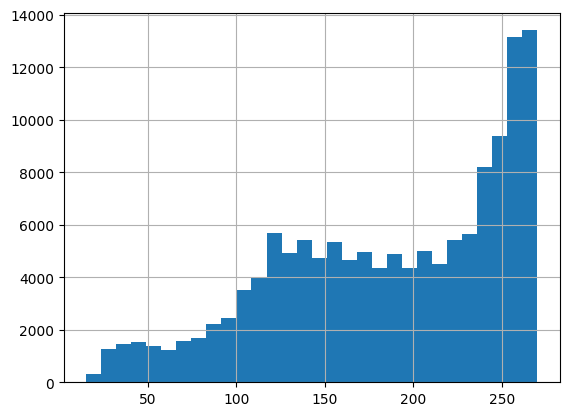

In [8]:
# plot histogram of token counts
train_df["token_count"].hist(bins=30)

In [9]:
train_df

,wiki_id,title,text,token_count
0,784611,Friedrich Stromeyer,Friedrich Stromeyer (* 2. August 1776 in Götti...,193
1,5871091,Siddiqiy Ajziy,"Saidahmad Siddiqiy (auch ""Saidahmadxoʻja""; kyr...",253
2,5365282,"7,5-cm-Leichtgeschütz 40","Das 7,5-cm-Leichtgeschütz 40 (kurz ""LG 40"") wa...",266
3,12114918,Tiberius Claudius Claudianus,<onlyinclude>* Tiberius Claudius Claudianus (S...,37
4,7596131,Gmina Stargard,"Die Gmina Stargard (von 1950 bis 2015 ""Stargar...",90
...,...,...,...,...
136714,11341584,Mabel Addis,Addis wurde als Mabel Holmes als Tochter von J...,203
136715,2277242,Robert Beyer (Tonmeister),Robert Beyer gehörte zu jenen radikalen Erneue...,244
136716,7957370,Gabriel Cyrille,Nach der Grundschule in Zinder besuchte Gabrie...,266
136717,3420897,Serbischer Psalter,Der Serbische Psalter (auch Codex Monacensis S...,148


In [10]:
# drop short texts
train_df = train_df[train_df["token_count"] > 30]
train_df

,wiki_id,title,text,token_count
0,784611,Friedrich Stromeyer,Friedrich Stromeyer (* 2. August 1776 in Götti...,193
1,5871091,Siddiqiy Ajziy,"Saidahmad Siddiqiy (auch ""Saidahmadxoʻja""; kyr...",253
2,5365282,"7,5-cm-Leichtgeschütz 40","Das 7,5-cm-Leichtgeschütz 40 (kurz ""LG 40"") wa...",266
3,12114918,Tiberius Claudius Claudianus,<onlyinclude>* Tiberius Claudius Claudianus (S...,37
4,7596131,Gmina Stargard,"Die Gmina Stargard (von 1950 bis 2015 ""Stargar...",90
...,...,...,...,...
136714,11341584,Mabel Addis,Addis wurde als Mabel Holmes als Tochter von J...,203
136715,2277242,Robert Beyer (Tonmeister),Robert Beyer gehörte zu jenen radikalen Erneue...,244
136716,7957370,Gabriel Cyrille,Nach der Grundschule in Zinder besuchte Gabrie...,266
136717,3420897,Serbischer Psalter,Der Serbische Psalter (auch Codex Monacensis S...,148


In [11]:
train_df.to_pickle("./data/wikipedia-22-12-de-no-emb-clean-selected-merged.pkl.gz", compression="gzip")